## La red neuronal anterior (DENSA O REGULAR) para pasar grados celsius a fahrenheit era un problema de REGRESION (la salida del modelo o la red neuronal es un NUMERO)

## El problema que vamos a abarcar ahora es un problema de CLASIFICACION, como entrada tenemos una imagen y la salida debe de decirnos a qué categoria pertenece (n categorias)

In [2]:
# En blanco y negro agregando escala de 0 mas blanco a 255 mas negro los pixeles, añadiendo estos pixeles a neuronas
# reduciremos la imagen a 28 px, por lo que 28x28 son 784 px o neuronas de entrada a la red y 10 categorias distintas en salida

In [1]:
# Las capas ocultas por si solas solo resuelven problemas LINEALES.
# Con la funcion de activacion resolveremos el problema de las capas ocultas por si solas, ya que una vez que una 
# neurona suma su sesgo y va a dar su resultado le aplicamos esta funcion de activacion (por ejemplo ReLU aplicandolo no admite las entradas menor a 0)



In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

2023-11-22 16:03:48.443297: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
datos,metadatos = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

In [3]:
metadatos

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_dir='/Users/adriansantoszurita/tensorflow_datasets/fashion_mnist/3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-0774

In [18]:
datos_entrenamiento, datos_pruebas = datos['train'], datos['test']

In [19]:
nombres_clases = metadatos.features['label'].names

In [20]:
nombres_clases

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [21]:
# Normalizamos los datos (pasar de 0-255 a 0-1)
def normalizar(imagenes,etiquetas):
    imagenes = tf.cast(imagenes, tf.float32)
    imagenes /= 255 # Aqui lo pasamos de 0-255 a 0-1
    return imagenes,etiquetas

# Normalizar los datos de entrenamiento y pruebas con la función que hicimos 
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

# Agregar a caché (usamos la memoria en lugar del disco, entrenamiento más rapido)
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

2023-11-22 16:36:58.650443: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


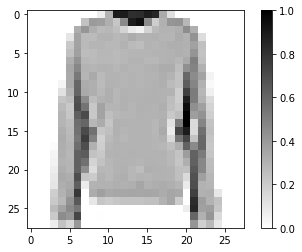

In [22]:
# Mostrarmos la imagen de los datos de pruebas, de momento vamos a mostrar solo la primera
for imagen, etiqueta in datos_entrenamiento.take(1):
    break
imagen = imagen.numpy().reshape((28,28)) # Redimensionamos, cosas de tensores

import matplotlib.pyplot as plt

# Dibujamos 
plt.figure()
plt.imshow(imagen,cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

2023-11-22 16:37:01.862503: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


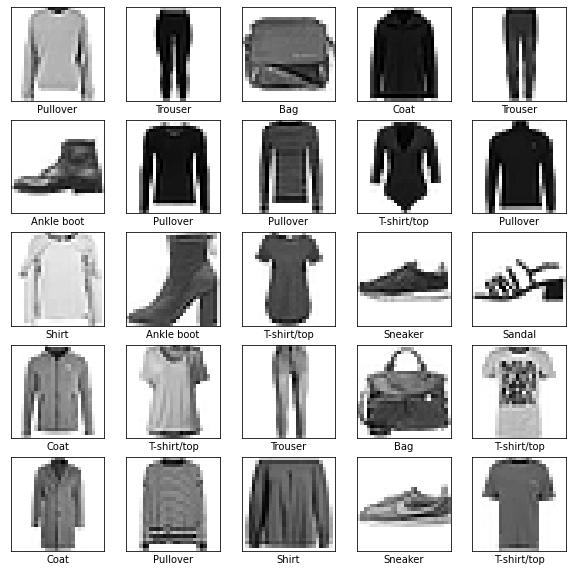

In [23]:
# Vamos a imprimir varias imagenes y que nos muestren cual es su categoria correcta con la que viene etiquetada
plt.figure(figsize=(10,10))
for i, (imagen,etiqueta) in enumerate(datos_entrenamiento.take(25)):
    imagen = imagen.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(imagen,cmap=plt.cm.binary)
    plt.xlabel(nombres_clases[etiqueta])
plt.show()

In [24]:
# Creamos el modelo con una red de tipo secuencial

modelo = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)), # 1 - blanco y negro
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax) # Para redes de clasificacion en salida
])

In [25]:
# Vamos a compilar el modelo

modelo.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [26]:
num_ej_entrenamiento = metadatos.splits["train"].num_examples
num_ej_pruebas = metadatos.splits["test"].num_examples

In [27]:
print(num_ej_entrenamiento)
print(num_ej_pruebas)

60000
10000


In [28]:
# Vamos a añadir lotes debido a que son 60000 neuronas
TAMAÑO_LOTE = 32

datos_entrenamiento= datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMAÑO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMAÑO_LOTE)

In [29]:
import math

# ENTRENAR
historial = modelo.fit(datos_entrenamiento, epochs=5, steps_per_epoch=math.ceil(num_ej_entrenamiento/TAMAÑO_LOTE))

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5194 - accuracy: 0.8167
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3841 - accuracy: 0.8612
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3468 - accuracy: 0.8727
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3220 - accuracy: 0.8817
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3055 - accuracy: 0.8872


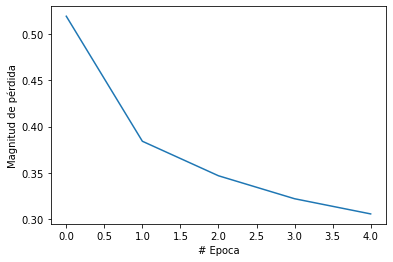

In [30]:
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(historial.history["loss"])

1/1 [==============================] - 0s 16ms/step


2023-11-22 16:41:19.465233: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-22 16:41:19.465294: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


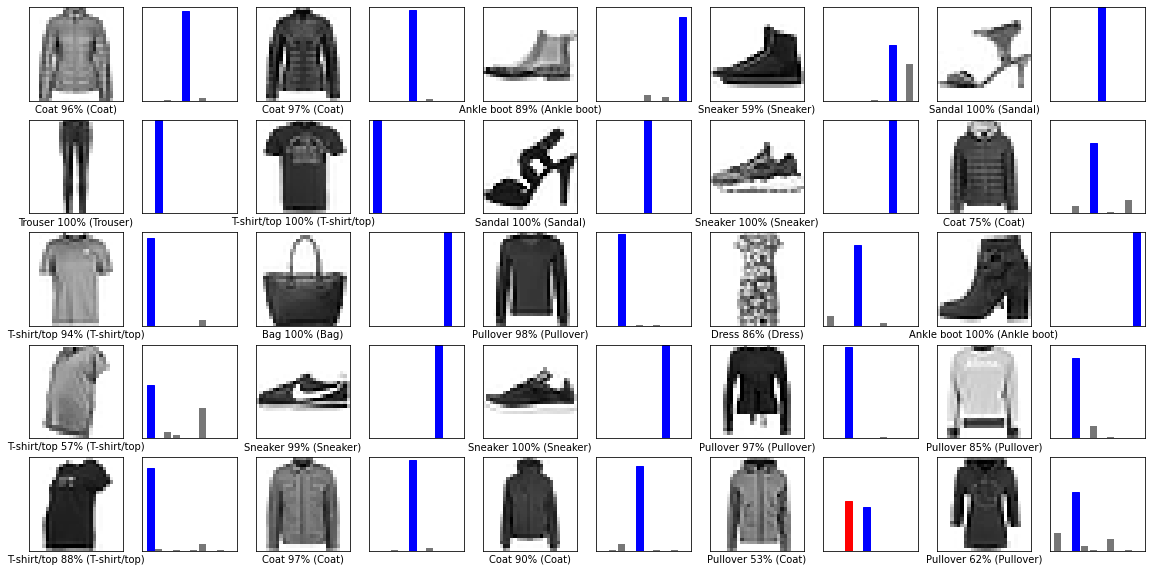

In [33]:
# Vamos a imprimir 25 imagenes del set de pruebas y que intente predecir
import numpy as np

for imagenes_prueba , etiquetas_prueba in datos_pruebas.take(1):
    imagenes_prueba = imagenes_prueba.numpy()
    etiquetas_prueba = etiquetas_prueba.numpy()
    predicciones = modelo.predict(imagenes_prueba)
    
def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
    arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img[...,0], cmap=plt.cm.binary)
    
    etiqueta_prediccion = np.argmax(arr_predicciones)
    if etiqueta_prediccion == etiqueta_real:
        color = 'blue' # Si acertamos
    else:
        color = 'red' # Si fallamos
        
    plt.xlabel("{} {:2.0f}% ({})".format(
        nombres_clases[etiqueta_prediccion],
        100*np.max(arr_predicciones),
        nombres_clases[etiqueta_real],
        color=color
    ))
    
def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
    arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    grafica = plt.bar(range(10),arr_predicciones, color='#777777')
    plt.ylim([0,1])
    etiqueta_prediccion = np.argmax(arr_predicciones)
    
    grafica[etiqueta_prediccion].set_color('red')
    grafica[etiqueta_real].set_color('blue')

filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas,2*filas))
for i in range(num_imagenes):
    plt.subplot(filas, 2*columnas, 2*i+1)
    graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
    plt.subplot(filas, 2*columnas, 2*i+2)
    graficar_valor_arreglo(i, predicciones, etiquetas_prueba)

In [34]:
# Coger cualquier indice del set de pruebas para ver su predicción
imagen = imagenes_prueba[5]
imagen= np.array([imagen])
prediccion = modelo.predict(imagen)

print("Prediccion: " + nombres_clases[np.argmax(prediccion[0])])

1/1 [==============================] - 0s 47ms/step
Prediccion: Trouser


In [35]:
# Vamos a exportar el modelo 
modelo.save('modelo_exportado.h5')

/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
